# LAB 4 - SARIMA MODELS

In this lab, you will be given two tasks:

1. Explore and understand code fitting seasonal ARIMA models to forecast corticosteroid drug sales in Australia.

2. Develop yourself code to forecast employment figures using SARIMA models.

## PART 1 - CORTICOSTEIROD DATA

The time series dataset `corticosteroid.xlsx` stores the corticosteroid drug sales in Australia (in millions of scripts per month) from
July 1991 to June 2008. The code below produces its time series plot.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_excel("CSV_FILES/corticosteroid.xlsx", index_col="Date", parse_dates=["Date"])
data = data.asfreq('ME')
data.head(3)

,h02
Date,
1991-07-31,0.429795
1991-08-31,0.400906
1991-09-30,0.432159


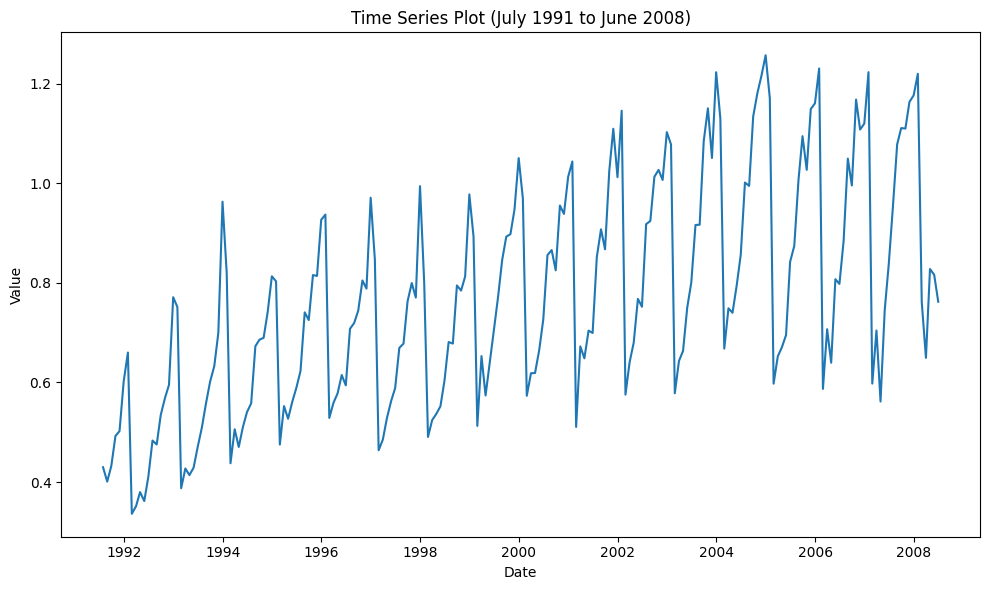

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Import the Excel file and parse the "Date" column as datetime,
# setting it as the index.
data = pd.read_excel("CSV_FILES/corticosteroid.xlsx", index_col="Date", parse_dates=["Date"])
data = data.asfreq('ME')

# Plot the time series (assuming the data values are in the first column)
plt.figure(figsize=(10, 6))
plt.plot(data.index, data.iloc[:, 0], linestyle='-')
plt.title("Time Series Plot (July 1991 to June 2008)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


In order to decide which transformation makes the data stationary, the code below produces the difference of consecutive values and the seasonal difference (and both). The plots also show the Dickey-Fuller test p-values. Which transformations make the series stationary?

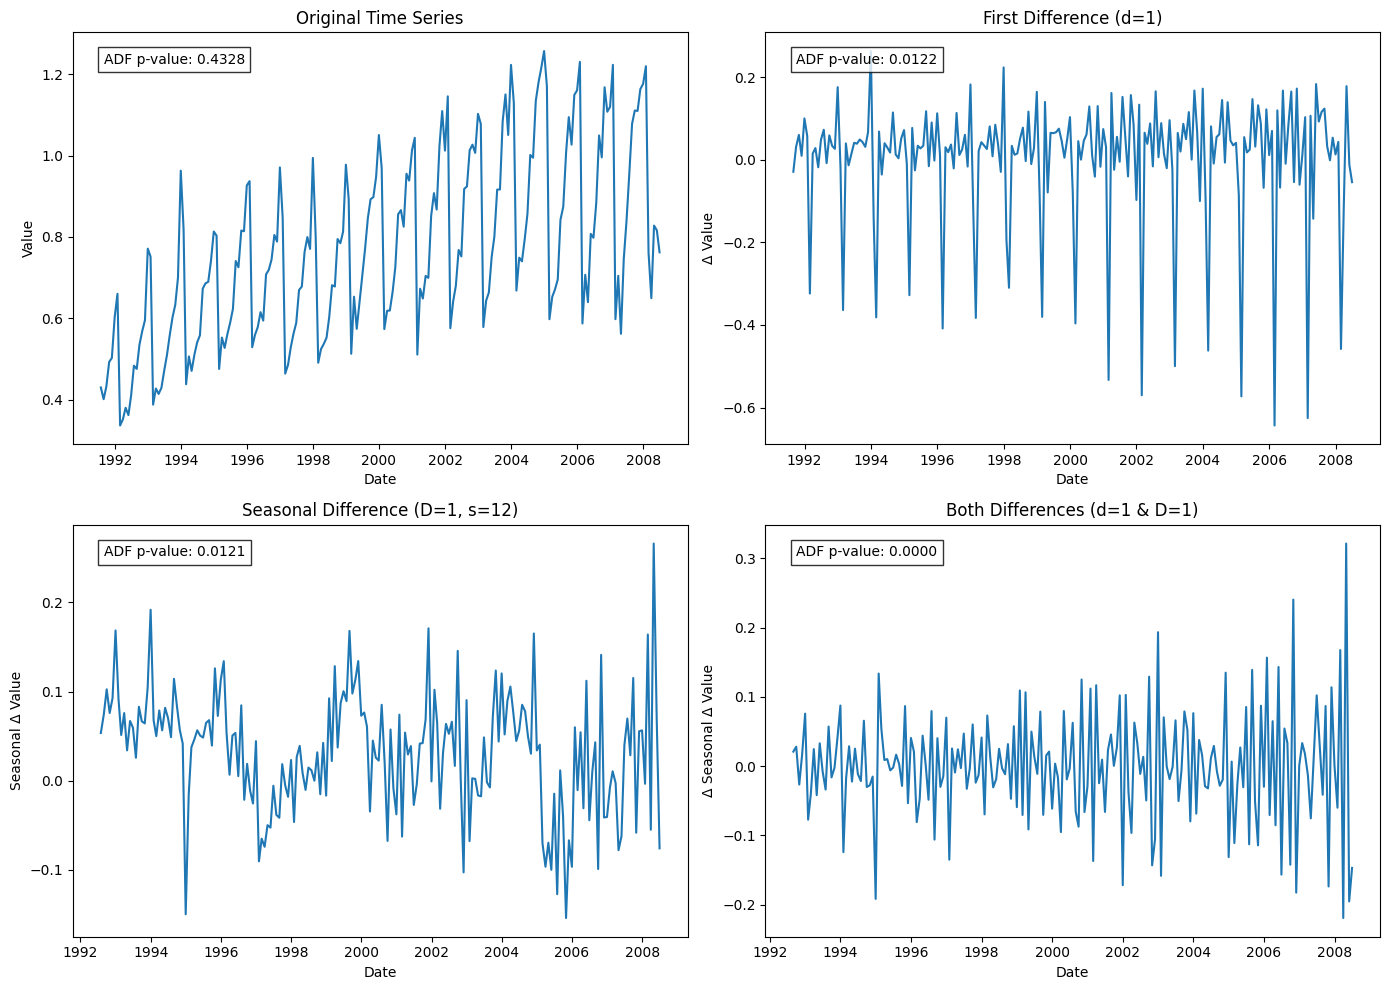

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Assume the time series values are in the first column
series = data.iloc[:, 0]

# Compute the first (non-seasonal) difference
diff_series = series.diff().dropna()

# For monthly data, seasonal difference is typically with period 12.
seasonal_diff = series.diff(12).dropna()

# Both differences: apply first difference then seasonal difference
both_diff = diff_series.diff(12).dropna()

# Compute ADF test p-values for each series
adf_original = adfuller(series.dropna())
p_value_original = adf_original[1]

adf_diff = adfuller(diff_series)
p_value_diff = adf_diff[1]

adf_seasonal = adfuller(seasonal_diff)
p_value_seasonal = adf_seasonal[1]

adf_both = adfuller(both_diff)
p_value_both = adf_both[1]

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Original time series with ADF p-value annotation
axs[0, 0].plot(series, linestyle='-')
axs[0, 0].set_title("Original Time Series")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")
axs[0, 0].text(0.05, 0.95, f"ADF p-value: {p_value_original:.4f}",
               transform=axs[0, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Top-Right: First Difference (non-seasonal) with ADF p-value annotation
axs[0, 1].plot(diff_series, linestyle='-')
axs[0, 1].set_title("First Difference (d=1)")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Δ Value")
axs[0, 1].text(0.05, 0.95, f"ADF p-value: {p_value_diff:.4f}",
               transform=axs[0, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Left: Seasonal Difference (assumed seasonal period s=12) with ADF p-value annotation
axs[1, 0].plot(seasonal_diff, linestyle='-')
axs[1, 0].set_title("Seasonal Difference (D=1, s=12)")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Seasonal Δ Value")
axs[1, 0].text(0.05, 0.95, f"ADF p-value: {p_value_seasonal:.4f}",
               transform=axs[1, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Right: Both Differences (non-seasonal then seasonal) with ADF p-value annotation
axs[1, 1].plot(both_diff,  linestyle='-')
axs[1, 1].set_title("Both Differences (d=1 & D=1)")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Δ Seasonal Δ Value")
axs[1, 1].text(0.05, 0.95, f"ADF p-value: {p_value_both:.4f}",
               transform=axs[1, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In the following we work with the data obtained from both differences. But one could have also selected the data from the seasonal only difference. The following code creates the ACF and PACF of the data. Is the data white noise? Are there correlations we can take advantage of?

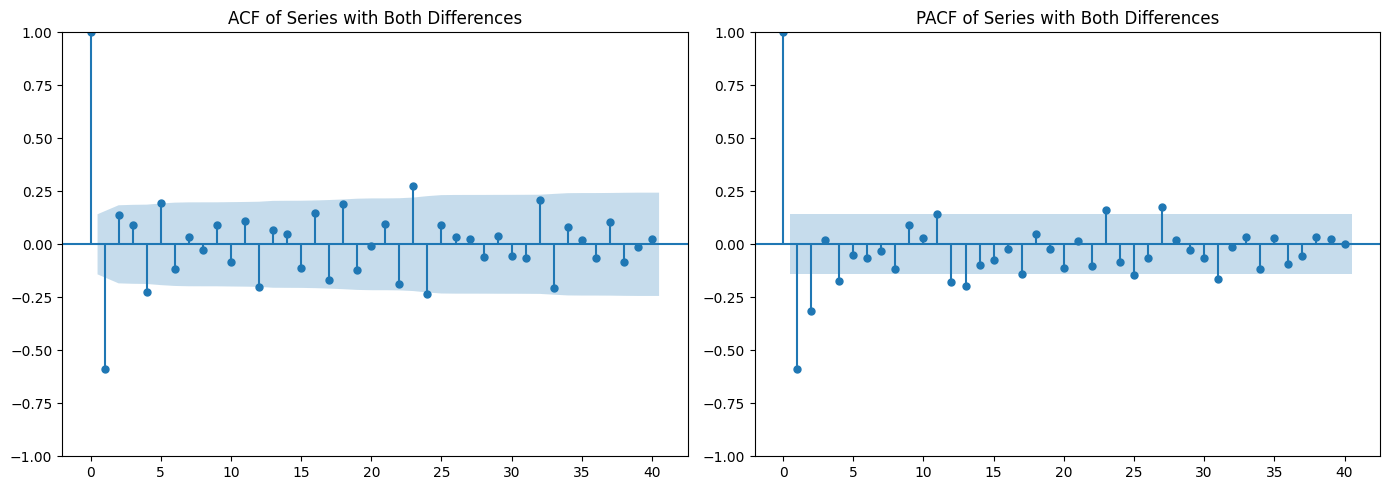

In [5]:
# Create ACF and PACF plots for the series with both differences
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(both_diff, lags=40, ax=axs[0])
axs[0].set_title("ACF of Series with Both Differences")

# PACF Plot
sm.graphics.tsa.plot_pacf(both_diff, lags=40, ax=axs[1], method='ywm')
axs[1].set_title("PACF of Series with Both Differences")

plt.tight_layout()
plt.show()

We now perform model selection. We consider all possible combinations of values for the parameters from 0 to 2. The following code fits a SARIMA model for every possible combination of parameters and computes the AIC and BIC of the model. The code will take a little bit of time and show some warnings - do not worry about them!!

In [6]:
import itertools
import warnings
warnings.filterwarnings("ignore")

# Define the grid for non-seasonal parameters p, q and seasonal parameters P, Q
p_values = range(3)
q_values = range(3)
P_values = range(3)
Q_values = range(3)

# Fixed differencing orders and seasonal period
d = 1
D = 1
s = 12

# List to store results
results_list = []

# Grid search over all combinations of p, q, P, Q
for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    try:
        model = sm.tsa.SARIMAX(series, order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': result.aic, 'BIC': result.bic
        })
    except Exception as e:
        # In case the model fails to fit, record NaN for AIC and BIC.
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': np.nan, 'BIC': np.nan
        })

# Convert the list of results into a DataFrame and sort by BIC (or AIC)
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='BIC')
print(results_df)

    p  d  q  P  D  Q   s         AIC         BIC
55  2  1  0  0  1  1  12 -560.000030 -546.990937
64  2  1  1  0  1  1  12 -559.578821 -543.317454
37  1  1  1  0  1  1  12 -555.877524 -542.868430
56  2  1  0  0  1  2  12 -559.025608 -542.764241
10  0  1  1  0  1  1  12 -552.328860 -542.572039
.. .. .. .. .. .. ..  ..         ...         ...
5   0  1  0  1  1  2  12 -464.723924 -451.714830
1   0  1  0  0  1  1  12 -456.814551 -450.310005
6   0  1  0  2  1  0  12 -447.804688 -438.047868
3   0  1  0  1  1  0  12 -427.510269 -421.005722
0   0  1  0  0  1  0  12 -419.585459 -416.333186

[81 rows x 9 columns]


The following code shows the best model according to AIC and BIC. As expected, the model chosen by BIC is simpler.

In [7]:
# Find the row with the minimum AIC
best_aic_row = results_df.loc[results_df['AIC'].idxmin()]
# Find the row with the minimum BIC
best_bic_row = results_df.loc[results_df['BIC'].idxmin()]

print("Model with the lowest AIC:")
print(best_aic_row)

print("\nModel with the lowest BIC:")
print(best_bic_row)


Model with the lowest AIC:
p        2.000000
d        1.000000
q        0.000000
P        2.000000
D        1.000000
Q        2.000000
s       12.000000
AIC   -562.761762
BIC   -539.995848
Name: 62, dtype: float64

Model with the lowest BIC:
p        2.000000
d        1.000000
q        0.000000
P        0.000000
D        1.000000
Q        1.000000
s       12.000000
AIC   -560.000030
BIC   -546.990937
Name: 55, dtype: float64


Let's have a look at the model selected by BIC. We print the output. Please make sure you understand all entries of the summary and that you are able to interpret what they tell you!

In [8]:
# Extract parameters for the best model
p = int(best_bic_row['p'])
d = int(best_bic_row['d'])
q = int(best_bic_row['q'])
P = int(best_bic_row['P'])
D = int(best_bic_row['D'])
Q = int(best_bic_row['Q'])
s = int(best_bic_row['s'])

# Refit the best SARIMA model on the series
best_model = sm.tsa.SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, s))
best_result = best_model.fit(disp=False)

# Print the model summary to the console
print(best_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  h02   No. Observations:                  204
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 284.000
Date:                              Thu, 13 Mar 2025   AIC                           -560.000
Time:                                      15:36:33   BIC                           -546.991
Sample:                                  07-31-1991   HQIC                          -554.731
                                       - 06-30-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8430      0.064    -13.262      0.000      -0.968      -0.718
ar.L2         -0.39

Let's now perform model validation. We create all residuals plots to check if the model adequately described the data. Again make sure you understand what you would like to see in each of the plots and how the ones produced deviate from optimal behavior.

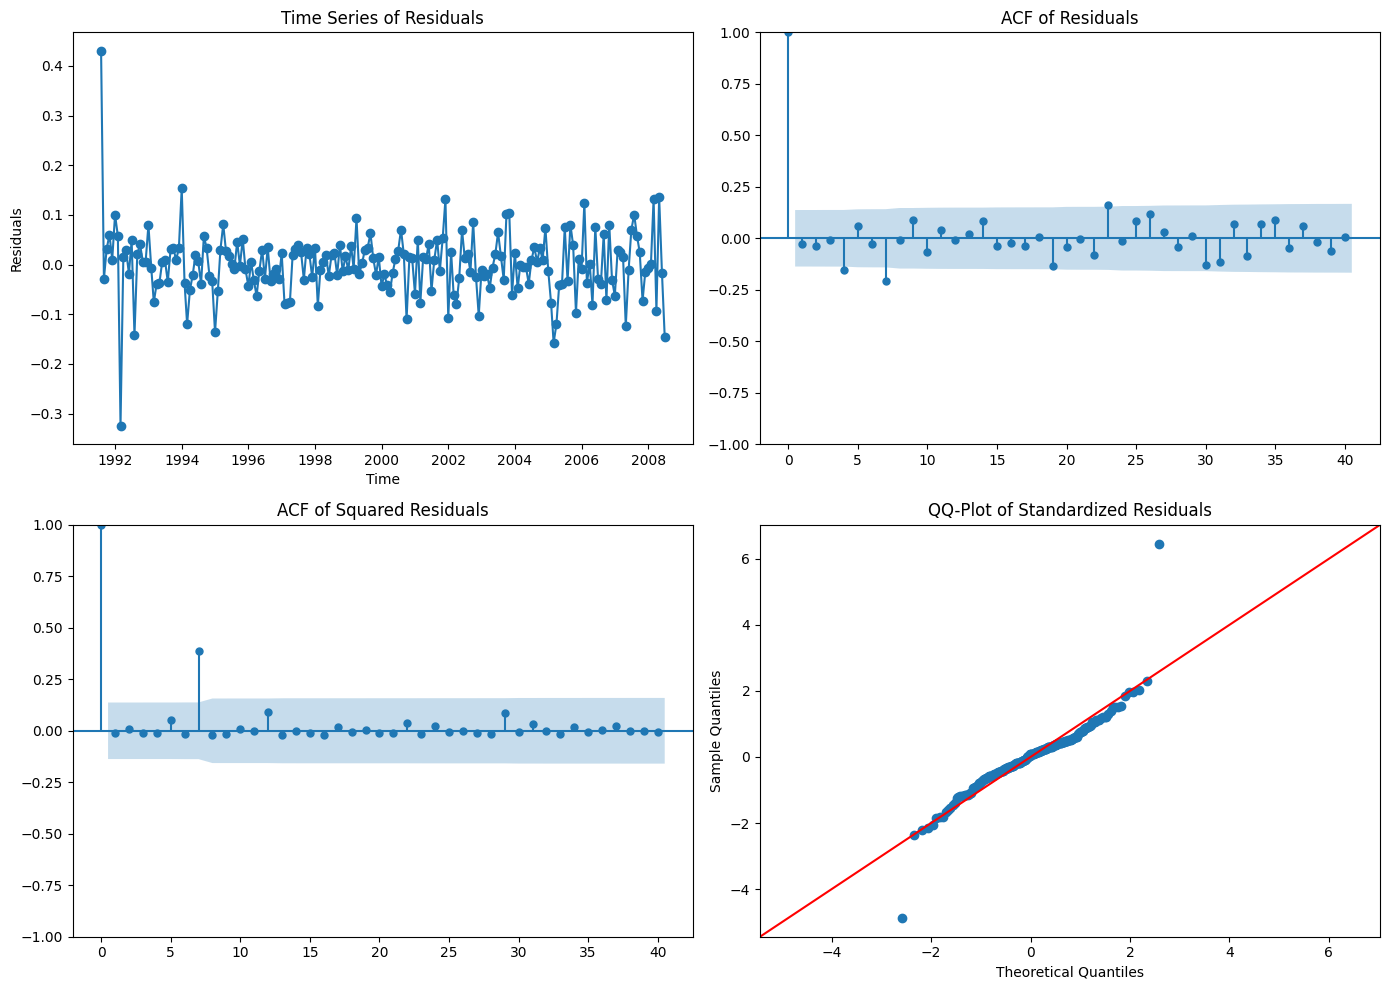

In [9]:
# Assuming 'best_result' is your fitted model from which we extract residuals.
resid = best_result.resid
resid_sq = resid ** 2

# Standardize the residuals for the QQ-plot.
resid_std = (resid - resid.mean()) / resid.std()

# Create a 2x2 grid of diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Time Series of Residuals
axs[0, 0].plot(resid, marker='o', linestyle='-')
axs[0, 0].set_title("Time Series of Residuals")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Residuals")

# Top-Right: ACF of Residuals
sm.graphics.tsa.plot_acf(resid, lags=40, ax=axs[0, 1])
axs[0, 1].set_title("ACF of Residuals")

# Bottom-Left: ACF of Squared Residuals
sm.graphics.tsa.plot_acf(resid_sq, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF of Squared Residuals")

# Bottom-Right: QQ-Plot of Standardized Residuals
sm.qqplot(resid_std, line='45', ax=axs[1, 1])
axs[1, 1].set_title("QQ-Plot of Standardized Residuals")

plt.tight_layout()
plt.show()


As the residuals look fairly ok, we now use the model for forecasting. The following code fits the model to all data prior to 2006 and forecasts at once the last two years of the series. The plot reports the actual values, the forecasts and 95% confidence intervals of the forecasts.
The model looks pretty good!!!

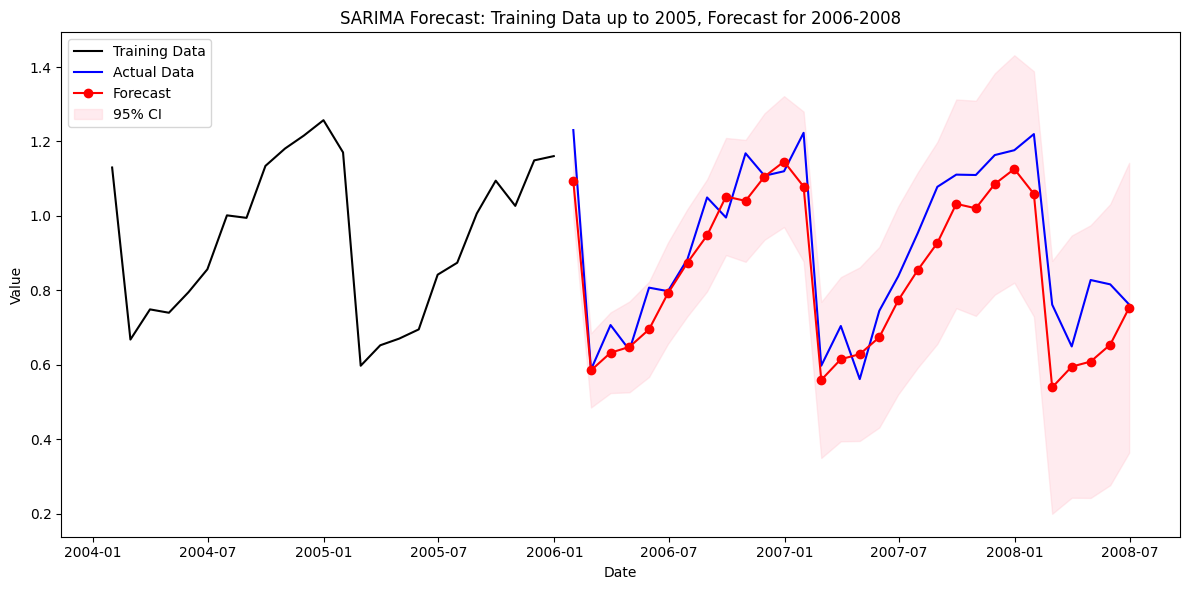

In [10]:
# 2. Split the data into training (up to December 2005) and test (from January 2006 onward)
train = data[data.index < '2006-01-01']
test = data[data.index >= '2006-01-01']

# 3. Fit the chosen SARIMA model on the training set
order = (p, d, q)
seasonal_order = (P, D, Q, s)
model = sm.tsa.SARIMAX(train.iloc[:, 0], order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)

# 4. Forecast for all periods in the test set (from January 2006 onward)
forecast_result = result.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 5. Plot the training data, test data, and forecast.
# Only plot data from 2004 onward for clarity.
plt.figure(figsize=(12, 6))
# Plot training data from 2004 onward
train_subset = train[train.index >= '2004-01-01']
plt.plot(train_subset.index, train_subset.iloc[:, 0], label="Training Data", color='black')
# Plot test (actual) data
plt.plot(test.index, test.iloc[:, 0], label="Actual Data", color='blue')
# Plot forecasted values
plt.plot(test.index, forecast_mean, label="Forecast", color='red', marker='o')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color="pink", alpha=0.3, label="95% CI")
plt.title("SARIMA Forecast: Training Data up to 2005, Forecast for 2006-2008")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# PART 2 - US FEMALE EMPLOYMENT


The time series dataset `employ.xlsx` stores US monthly employment
figures for females aged 20 years and over from 1948 to 1981. We first plot the data.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
data = pd.read_excel("CSV_FILES/employ.xlsx", index_col="Date", parse_dates=["Date"])

data = data.resample('ME').ffill()
data.head(3)

,employment
Date,
1948-01-31,446
1948-02-29,650
1948-03-31,592


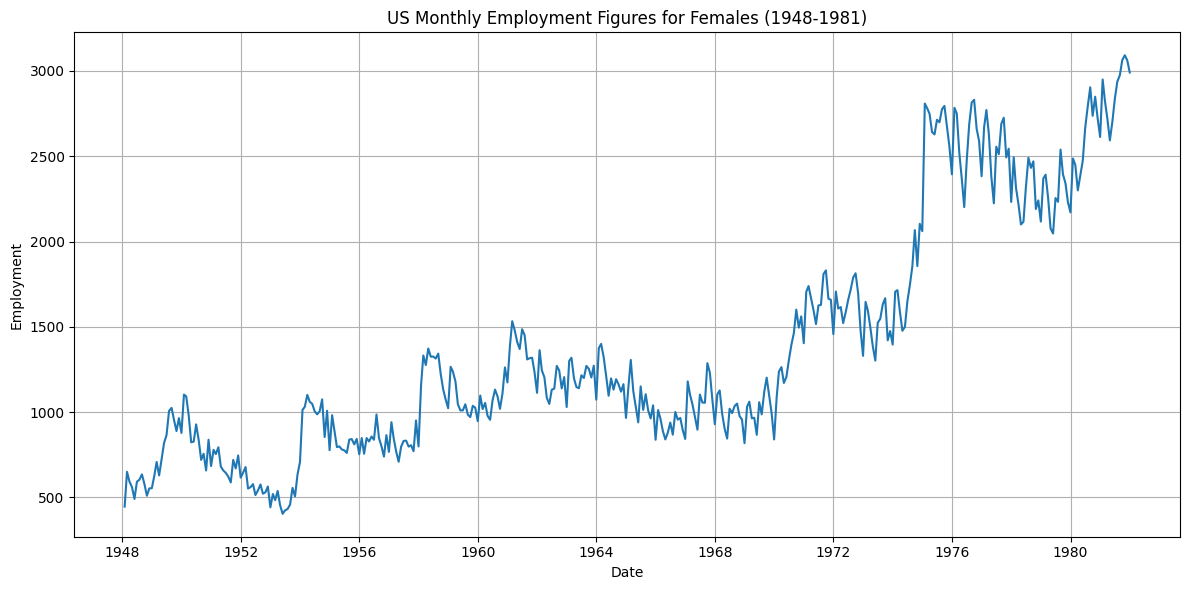

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
data = pd.read_excel("CSV_FILES/employ.xlsx", index_col="Date", parse_dates=["Date"])

data = data.resample('ME').ffill()

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(data['employment'], linestyle='-')
plt.title("US Monthly Employment Figures for Females (1948-1981)")
plt.xlabel("Date")
plt.ylabel("Employment")
plt.grid(True)
plt.tight_layout()
plt.show()

To check if any seasonality is present you could try and zoom in a specific period. For instance, create the time series plot consider only 1963-1965.

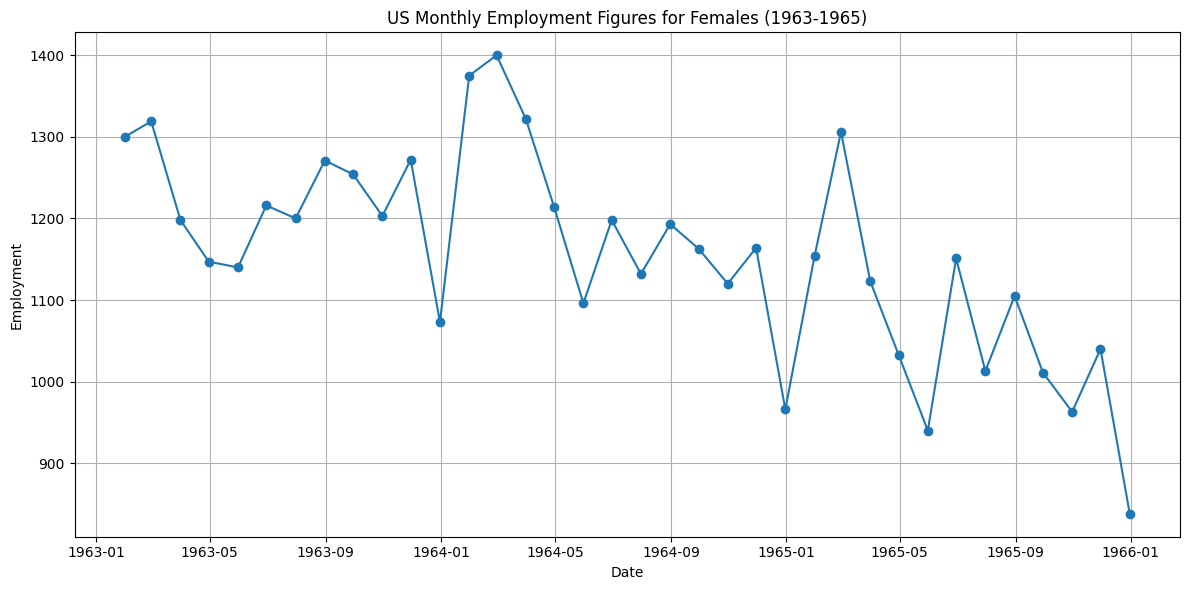

In [15]:
# Subset the data to include only the years 1963 through 1965.
subset = data.loc['1963':'1965']

# Create the time series plot for the selected period
plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['employment'], marker='o', linestyle='-')
plt.title("US Monthly Employment Figures for Females (1963-1965)")
plt.xlabel("Date")
plt.ylabel("Employment")
plt.grid(True)
plt.tight_layout()
plt.show()

In order to choose which differencing to use, create the plots of the possible differences and select the parameters d and D of the SARIMA models.

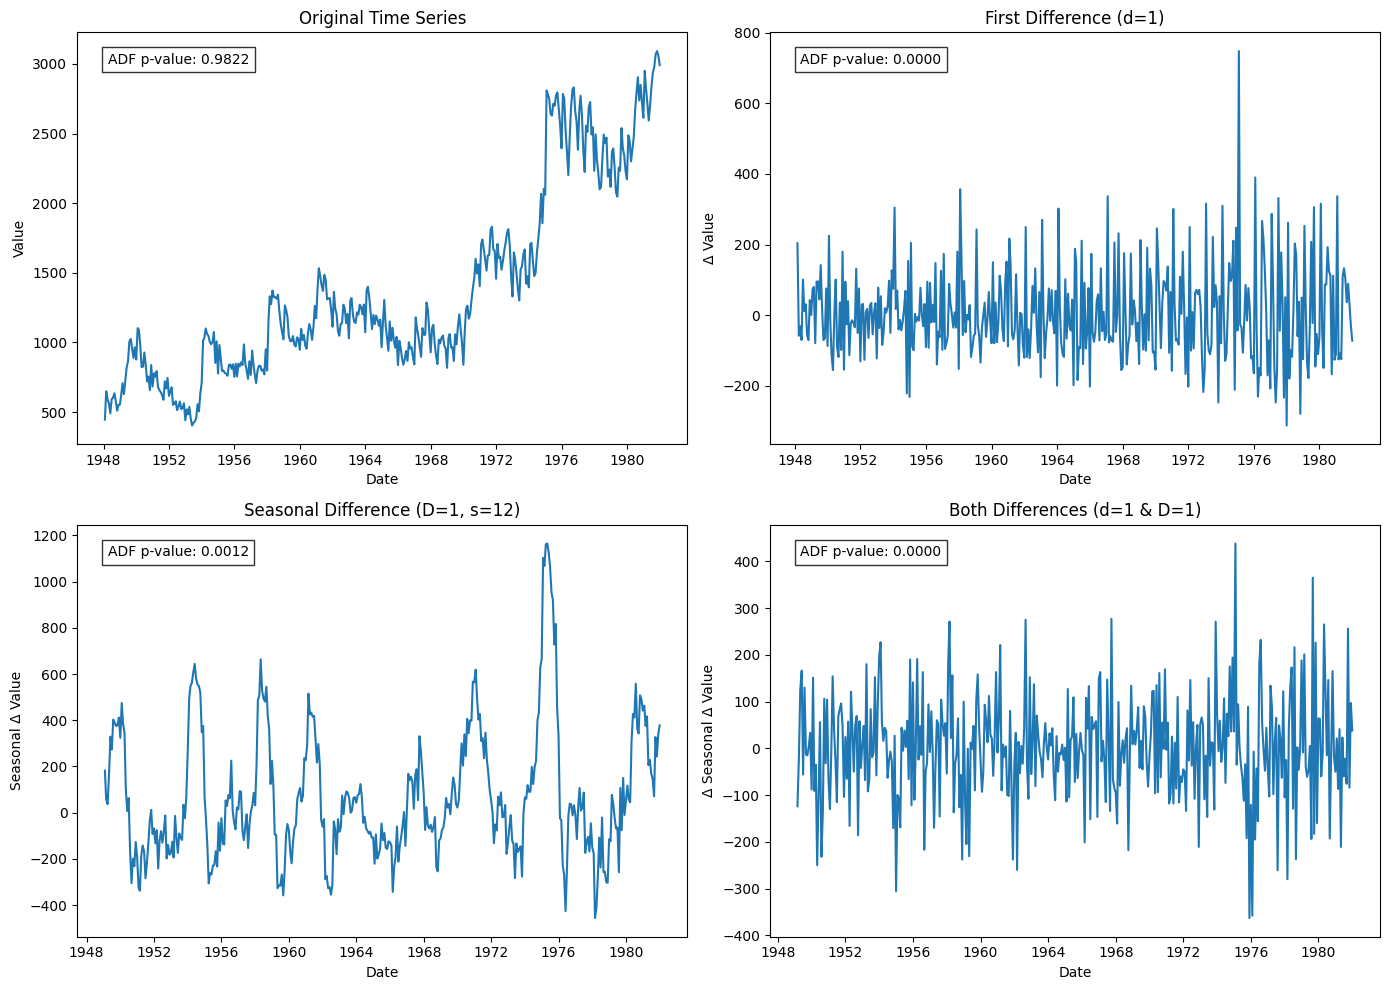

In [16]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Assume the time series values are in the first column
series = data.iloc[:, 0]

# Compute the first (non-seasonal) difference
diff_series = series.diff().dropna()

# For monthly data, seasonal difference is typically with period 12.
seasonal_diff = series.diff(12).dropna()

# Both differences: apply first difference then seasonal difference
both_diff = diff_series.diff(12).dropna()

# Compute ADF test p-values for each series
adf_original = adfuller(series.dropna())
p_value_original = adf_original[1]

adf_diff = adfuller(diff_series)
p_value_diff = adf_diff[1]

adf_seasonal = adfuller(seasonal_diff)
p_value_seasonal = adf_seasonal[1]

adf_both = adfuller(both_diff)
p_value_both = adf_both[1]

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Original time series with ADF p-value annotation
axs[0, 0].plot(series, linestyle='-')
axs[0, 0].set_title("Original Time Series")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")
axs[0, 0].text(0.05, 0.95, f"ADF p-value: {p_value_original:.4f}",
               transform=axs[0, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Top-Right: First Difference (non-seasonal) with ADF p-value annotation
axs[0, 1].plot(diff_series, linestyle='-')
axs[0, 1].set_title("First Difference (d=1)")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Δ Value")
axs[0, 1].text(0.05, 0.95, f"ADF p-value: {p_value_diff:.4f}",
               transform=axs[0, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Left: Seasonal Difference (assumed seasonal period s=12) with ADF p-value annotation
axs[1, 0].plot(seasonal_diff, linestyle='-')
axs[1, 0].set_title("Seasonal Difference (D=1, s=12)")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Seasonal Δ Value")
axs[1, 0].text(0.05, 0.95, f"ADF p-value: {p_value_seasonal:.4f}",
               transform=axs[1, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Right: Both Differences (non-seasonal then seasonal) with ADF p-value annotation
axs[1, 1].plot(both_diff,  linestyle='-')
axs[1, 1].set_title("Both Differences (d=1 & D=1)")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Δ Seasonal Δ Value")
axs[1, 1].text(0.05, 0.95, f"ADF p-value: {p_value_both:.4f}",
               transform=axs[1, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


Creat the autocorrelation and partial autocorrelation plots of the data you chose in the previous step.

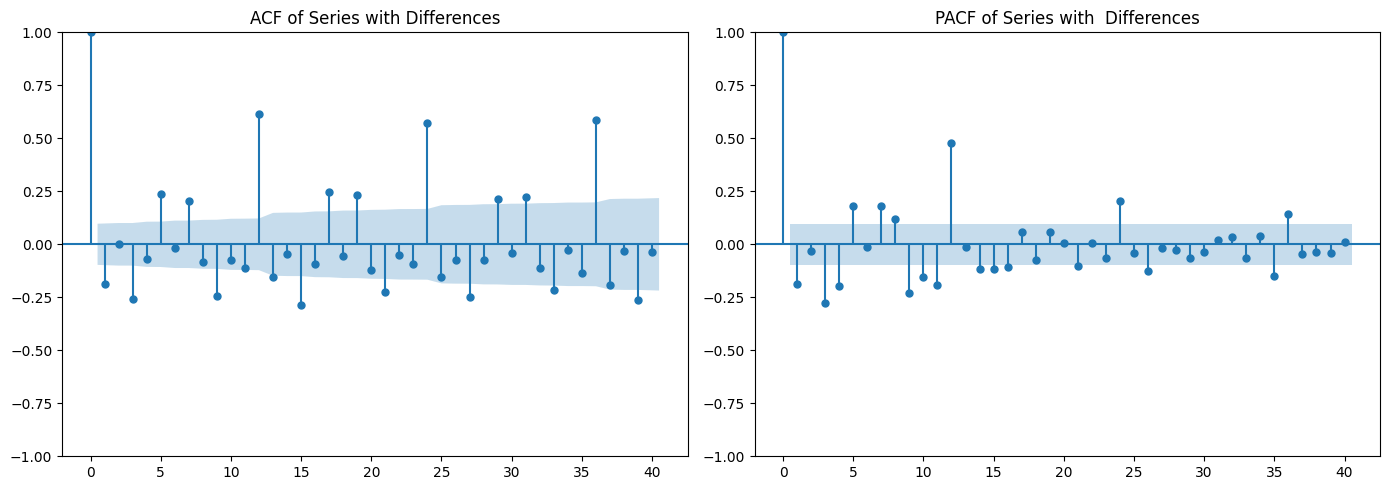

In [17]:
# Create ACF and PACF plots for the series with both differences
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(diff_series, lags=40, ax=axs[0])
axs[0].set_title("ACF of Series with Differences")

# PACF Plot
sm.graphics.tsa.plot_pacf(diff_series, lags=40, ax=axs[1], method='ywm')
axs[1].set_title("PACF of Series with  Differences")

plt.tight_layout()
plt.show()


Now use grid search to compute the AIC and BIC of various SARIMA models and select your favourite model.

In [19]:
import itertools
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Define the grid for non-seasonal parameters p, q and seasonal parameters P, Q
p_values = range(3)
q_values = range(3)
P_values = range(3)
Q_values = range(3)

# Fixed differencing orders and seasonal period
d = 1
D = 0
s = 12

# List to store results
results_list = []

# Grid search over all combinations of p, q, P, Q
for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    try:
        model = sm.tsa.SARIMAX(series, order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': result.aic, 'BIC': result.bic
        })
    except Exception as e:
        # In case the model fails to fit, record NaN for AIC and BIC.
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': np.nan, 'BIC': np.nan
        })

# Convert the list of results into a DataFrame and sort by BIC (or AIC)
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='BIC')
print(results_df)

# Find the row with the minimum AIC
best_aic_row = results_df.loc[results_df['AIC'].idxmin()]
# Find the row with the minimum BIC
best_bic_row = results_df.loc[results_df['BIC'].idxmin()]

print("Model with the lowest AIC:")
print(best_aic_row)

print("\nModel with the lowest BIC:")
print(best_bic_row)

    p  d  q  P  D  Q   s          AIC          BIC
50  1  1  2  1  0  2  12    76.237063   104.298756
58  2  1  0  1  0  1  12  4806.034707  4826.078773
31  1  1  0  1  0  1  12  4810.220859  4826.256111
4   0  1  0  1  0  1  12  4815.113091  4827.139530
22  0  1  2  1  0  1  12  4807.434925  4827.478991
.. .. .. .. .. .. ..  ..          ...          ...
45  1  1  2  0  0  0  12  5095.596207  5111.631460
72  2  1  2  0  0  0  12  5096.151755  5116.195821
54  2  1  0  0  0  0  12  5104.596428  5116.622868
0   0  1  0  0  0  0  12  5114.851480  5118.860294
77  2  1  2  1  0  2  12          NaN          NaN

[81 rows x 9 columns]
Model with the lowest AIC:
p        1.000000
d        1.000000
q        2.000000
P        1.000000
D        0.000000
Q        2.000000
s       12.000000
AIC     76.237063
BIC    104.298756
Name: 50, dtype: float64

Model with the lowest BIC:
p        1.000000
d        1.000000
q        2.000000
P        1.000000
D        0.000000
Q        2.000000
s       12.0000

Visualize now the summary of your favourite model.

In [20]:
# Extract parameters for the best model
p = int(best_bic_row['p'])
d = int(best_bic_row['d'])
q = int(best_bic_row['q'])
P = int(best_bic_row['P'])
D = int(best_bic_row['D'])
Q = int(best_bic_row['Q'])
s = int(best_bic_row['s'])

# Refit the best SARIMA model on the series
best_model = sm.tsa.SARIMAX(series, order=(p, d, q), seasonal_order=(P, D, Q, s))
best_result = best_model.fit(disp=False)

# Print the model summary to the console
print(best_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         employment   No. Observations:                  408
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood                 -31.119
Date:                            Thu, 13 Mar 2025   AIC                             76.237
Time:                                    15:57:18   BIC                            104.299
Sample:                                01-31-1948   HQIC                            87.342
                                     - 12-31-1981                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000         -0        inf      0.000      -1.000      -1.000
ma.L1          0.1561      0.115   

Create the residual diagnostics of your chosen model.

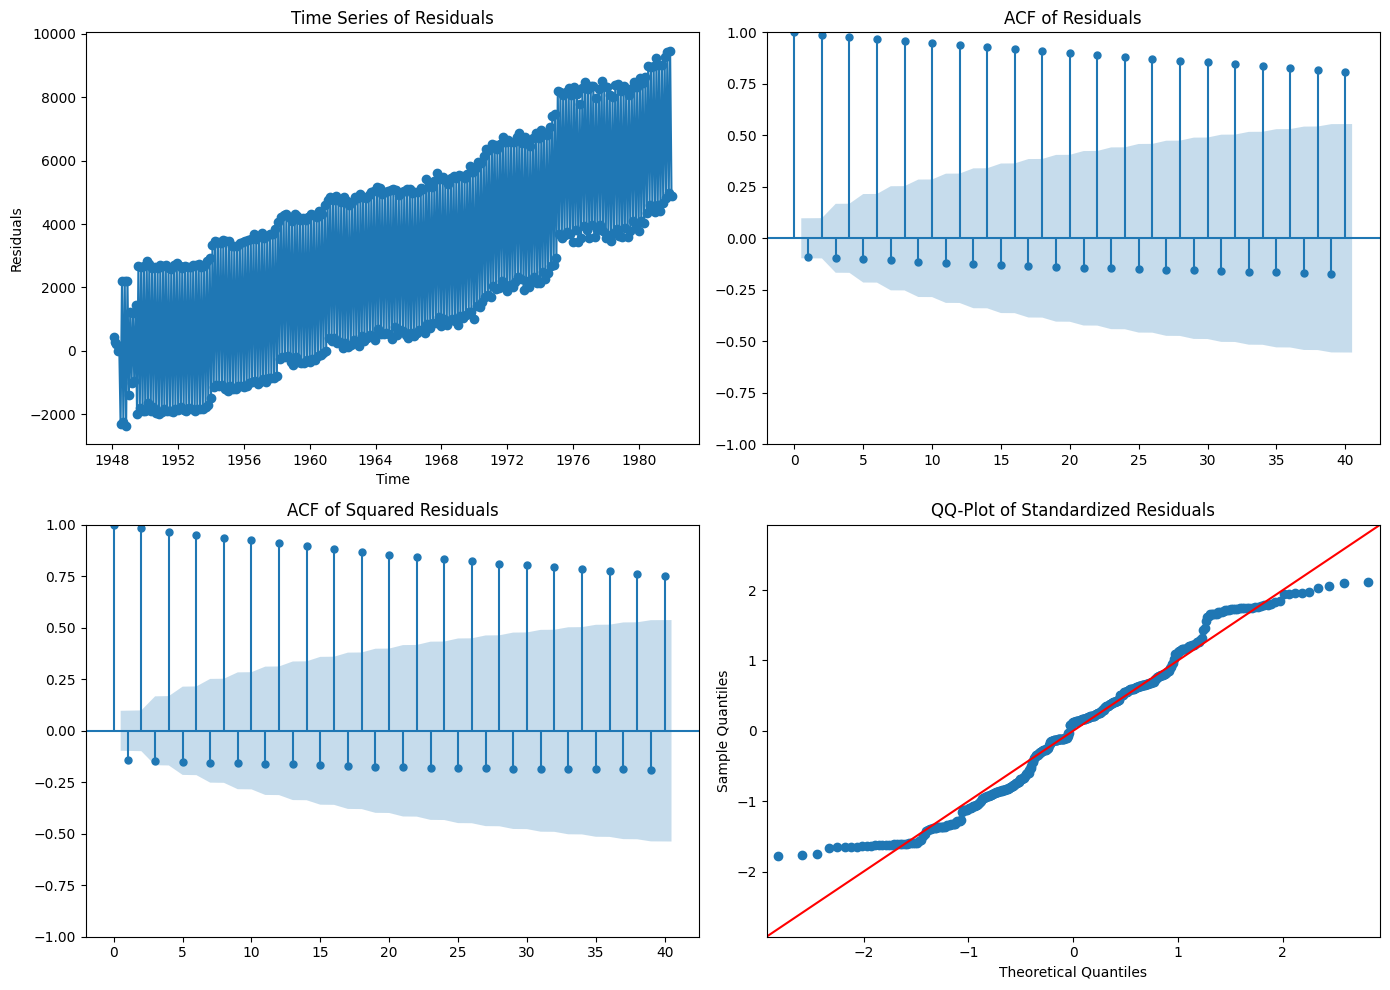

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming 'best_result' is your fitted model from which we extract residuals.
resid = best_result.resid
resid_sq = resid ** 2

# Standardize the residuals for the QQ-plot.
resid_std = (resid - resid.mean()) / resid.std()

# Create a 2x2 grid of diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Time Series of Residuals
axs[0, 0].plot(resid, marker='o', linestyle='-')
axs[0, 0].set_title("Time Series of Residuals")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Residuals")

# Top-Right: ACF of Residuals
sm.graphics.tsa.plot_acf(resid, lags=40, ax=axs[0, 1])
axs[0, 1].set_title("ACF of Residuals")

# Bottom-Left: ACF of Squared Residuals
sm.graphics.tsa.plot_acf(resid_sq, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF of Squared Residuals")

# Bottom-Right: QQ-Plot of Standardized Residuals
sm.qqplot(resid_std, line='45', ax=axs[1, 1])
axs[1, 1].set_title("QQ-Plot of Standardized Residuals")

plt.tight_layout()
plt.show()

Perform forecasting using your chosen model. First select data prior to 1978 to fit the model and forecast the remaining of the time series. Then try the same but this time using data prior to 1975 as train data. What do you observe?

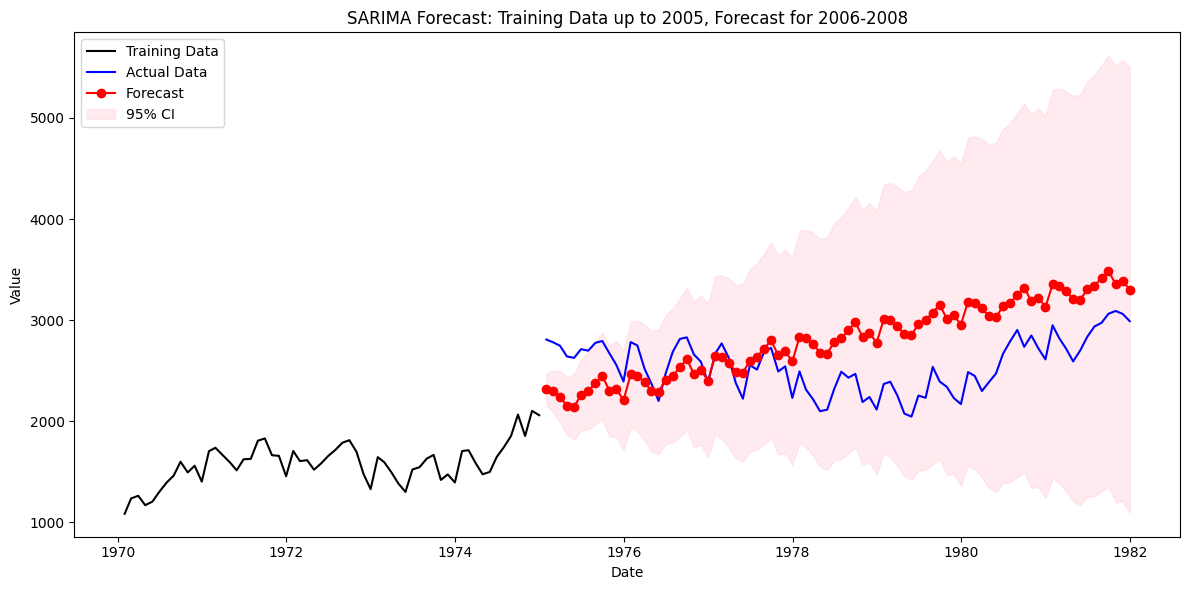

In [22]:
train = data[data.index < '1975-01-01']
test = data[data.index >= '1975-01-01']

# 3. Fit the chosen SARIMA model on the training set
order = (p, d, q)
seasonal_order = (P, D, Q, s)
model = sm.tsa.SARIMAX(train.iloc[:, 0], order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)


forecast_result = result.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 5. Plot the training data, test data, and forecast.

plt.figure(figsize=(12, 6))
train_subset = train[train.index >= '1970-01-01']
plt.plot(train_subset.index, train_subset.iloc[:, 0], label="Training Data", color='black')
# Plot test (actual) data
plt.plot(test.index, test.iloc[:, 0], label="Actual Data", color='blue')
# Plot forecasted values
plt.plot(test.index, forecast_mean, label="Forecast", color='red', marker='o')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color="pink", alpha=0.3, label="95% CI")
plt.title("SARIMA Forecast: Training Data up to 2005, Forecast for 2006-2008")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

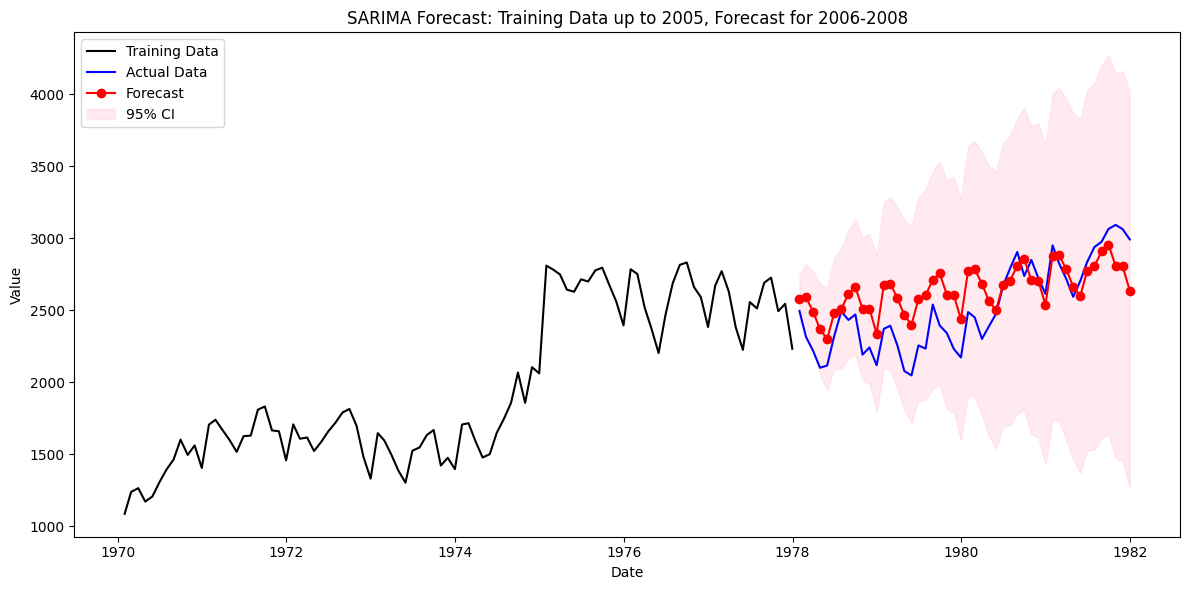

In [23]:
train = data[data.index < '1978-01-01']
test = data[data.index >= '1978-01-01']

# 3. Fit the chosen SARIMA model on the training set
order = (p, d, q)
seasonal_order = (P, D, Q, s)
model = sm.tsa.SARIMAX(train.iloc[:, 0], order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)


forecast_result = result.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 5. Plot the training data, test data, and forecast.

plt.figure(figsize=(12, 6))
train_subset = train[train.index >= '1970-01-01']
plt.plot(train_subset.index, train_subset.iloc[:, 0], label="Training Data", color='black')
# Plot test (actual) data
plt.plot(test.index, test.iloc[:, 0], label="Actual Data", color='blue')
# Plot forecasted values
plt.plot(test.index, forecast_mean, label="Forecast", color='red', marker='o')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color="pink", alpha=0.3, label="95% CI")
plt.title("SARIMA Forecast: Training Data up to 2005, Forecast for 2006-2008")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()